# Intialize NMRlipids databank

In [1]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import MDAnalysis
import urllib.request
import yaml
import random


# This defines the path for the NMRlipids databank on your computer. 
# Before running this you need to clone the NMRlipids datbank git locally 
# from here https://github.com/NMRLipids/Databank
# Default is that this repository and the NMRlipids databank repository are cloned to the same folder.
# If this is not the case, change this to the folder where the NMRlipids databank repository is located.
databankPath =  '../../Databank/'

# This enales the access to functions defined in the NMRlipids databank.
sys.path.insert(1, databankPath + '/Scripts/BuildDatabank/')
from databankLibrary import * 

# This initializes the databank and stores the information of all simulations into a list.
# Each list item contains the information from README.yaml file of the given simulation.
systems = initialize_databank(databankPath)

Databank initialized from the folder: /home/sosamuli/work/NMRlipids/Databank/Data/Simulations


# Select random simulation for example and show its content

In [2]:
 ### To exemplify the analysis of any simulation, we select randomly one simulation ID
randomID = random.randint(1, len(systems))
#randomID=546
print('ID of the selected simulation: ', randomID)


 ### This loops over all the simulations in the databank
for system in systems:
    
    ### To lighten up the example, we randomly select one simulation
    ### To run analyses for all simulations, comment out two lines below
    if system['ID'] != randomID:
        continue
    
    ### This prints the information about the selected simulation
    print_README(system)
 

 ### Remove comments from below two lines to see explanation on content in each simulation
#print('\n Explanation of simulation content')
#print_README('example')

ID of the selected simulation:  632
DOI:
  10.5281/zenodo.6943413
SOFTWARE:
  gromacs
TRJ:
  [['DYPC_small.xtc']]
TPR:
  [['DYPC_small.tpr']]
PREEQTIME:
  0
TIMELEFTOUT:
  0
COMPOSITION:
  {'DYPC': {'NAME': 'DYPC', 'MAPPING': 'mappingDYPCcharmm.yaml', 'COUNT': [32, 32]}, 'SOL': {'NAME': 'TIP3', 'MAPPING': 'mappingTIP3PCHARMMgui.yaml', 'COUNT': 3200}}
DIR_WRK:
  /home/lara/Databank
PUBLICATION:
  None
AUTHORS_CONTACT:
  Javanainen, Matti
SYSTEM:
  64DYPC_3200SOL_333K
SOFTWARE_VERSION:
  None
FF:
  CHARMM36
FF_SOURCE:
  CHARMM-GUI
FF_DATE:
  None
CPT:
  [['DYPC_small.cpt']]
LOG:
  None
TOP:
  [['DYPC_small.top']]
GRO:
  [['DYPC_small.gro']]
TRAJECTORY_SIZE:
  64142504
TRJLENGTH:
  1001000.0
TEMPERATURE:
  333.15
NUMBER_OF_ATOMS:
  17664
DATEOFRUNNING:
  01/09/2022
TYPEOFSYSTEM:
  lipid bilayer
ID:
  632
EXPERIMENT:
  {'ORDERPARAMETER': {'DYPC': {}}, 'FORMFACTOR': {}}
path:
  cb9/dad/cb9dad3050719328c5a8e75096dd072d5e95cd11/34819948036ac704abbdcbee766296da3ecb716f/


# Show analyzed properties stored in the NMRlipids databank for the selected system: 

Membrane area per lipid: 70.8534216714072 

Membrane thickness: 3.796890510559082 

Relative equilibration time for each lipid in the simulation:
DYPC: 0.04291341008408897


Plot form factor and C-H bond order parameters from the simulation together with experimental data if avaible 

DYPC
Databank initialized from the folder: /home/sosamuli/work/NMRlipids/Databank/Data/Simulations
DOI:  10.5281/zenodo.6943413
Force field quality not found


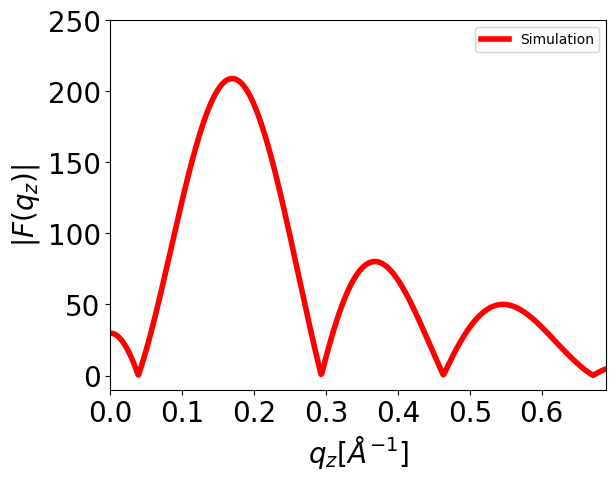

Form factor plotting failed


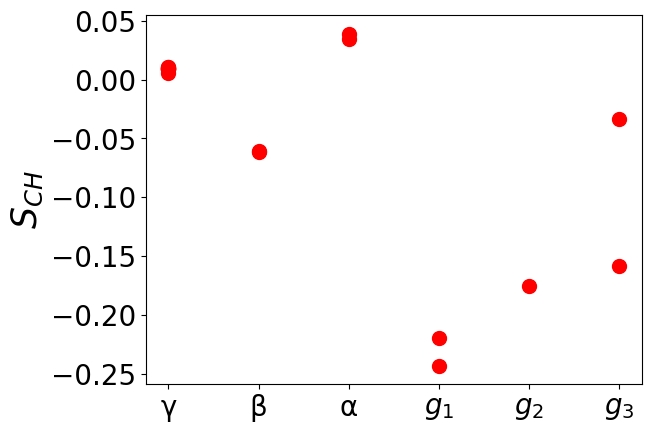

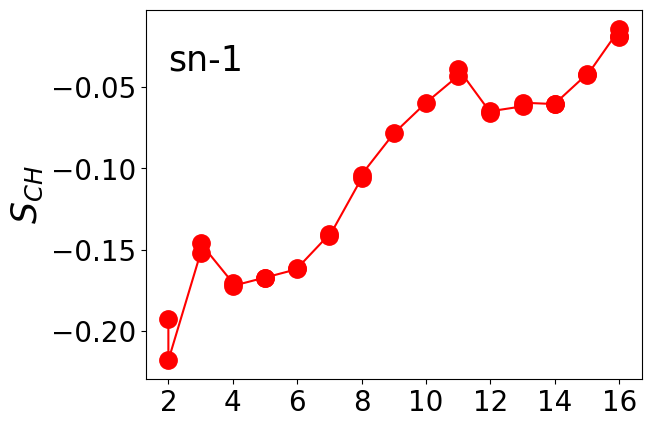

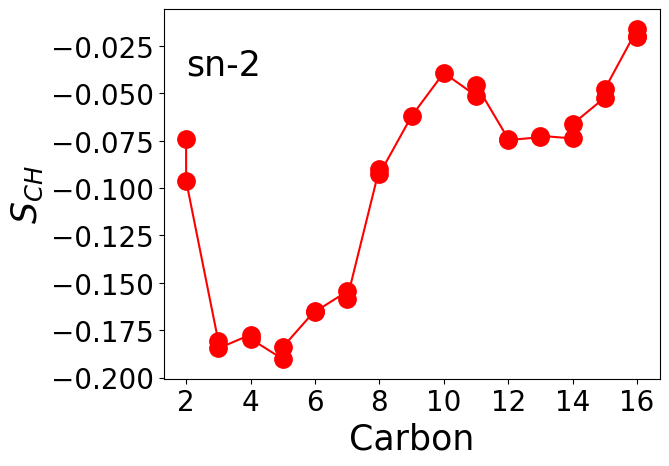

In [3]:
## Membrane area per lipid, thickness, relative equilibration time, C-H bond order parameters 
## and X-ray scattering form factors shown for the selected random simulation.


for system in systems:
    
    ### To lighten up the example, we randomly select one simulation
    ### To run analyses for all simulations, comment out two lines below
    if system['ID'] != randomID:
        continue
    
    APL = CalcAreaPerMolecule(system)
    print('Membrane area per lipid:' , APL, '\n')

    thickness = GetThickness(system)
    print('Membrane thickness:' , thickness, '\n')
    
    print('Relative equilibration time for each lipid in the simulation:')
    ShowEquilibrationTimes(system)
    print('\n')
    
    print('Plot form factor and C-H bond order parameters from the simulation together with experimental data if avaible \n')
    for lipid in system['COMPOSITION']:
        if lipid not in lipids_dict:
            continue
        print(lipid)
        try:
            plotSimulation(system['ID'], lipid)
        except:
            print('Plotting failed for ' ,lipid)
    
    break

# Selects a random simulation with the trajectory size below 100Mb and calculates P-N vector angle with respect to membrane normal for all lipids for which P and N atoms are available in headgroup

In [4]:
## Print simulation specific 

Patom_UNI = 'M_G3P2_M'   # universal name of phophate headgroup atom 
Natom_UNI = 'M_G3N6_M'   # universal name of nitrogen headgroup atom


## Finding a random simulation with smaller than 100Mb trajectory for testing
systemFound = False
while not systemFound:
    randomID = random.randint(1, len(systems))
    for system in systems:
        if system['ID'] == randomID:
            # This filters out larger than 100Mb trajectories for testing
            if system['TRAJECTORY_SIZE'] > 100000000:
                break
            else:
                systemFound = True
                break
       
print('ID number of the selected simulation: ', randomID)

for system in systems:

    # This filters other than the randomly selected simulation.
    # Remove this to analyze all simulations 
    if system['ID'] != randomID:
        continue
    
    # Creates MDAnalysis universe from the simulation
    # This will also download simulation files if not yet available locally
    MDAuni = system2MDanalysisUniverse(system)
    
    # Loops over molecules and calculates P-N vector angle if atoms are found
    for molecule in system['COMPOSITION']:
        if molecule not in lipids_dict:
            continue
        print('\n Analysing ' + molecule)
        Patom_SIM = simulation2universal_atomnames(system,molecule,Patom_UNI)
        #print(Patom_SIM)
        Natom_SIM = simulation2universal_atomnames(system,molecule,Natom_UNI)
        #print(Natom_SIM)
        if Patom_SIM == None or Natom_SIM == None:
            continue
        
        #print(molecule, Patom_SIM, Natom_SIM)
        resname = system['COMPOSITION'][molecule]['NAME']
        PNangles = read_trj_PN_angles(resname, Patom_SIM, Natom_SIM, MDAuni)
        
        print('PN vector angle for ' + molecule + ':' + str(PNangles[2]) + ' +/- ' + str(PNangles[3]) + '\n')
        
    #if 'POPC' in molecule:
    #    mappingFilePath = databankPath + '/Scripts/BuildDatabank/mapping_files/' + system['COMPOSITION'][molecule]['MAPPING']
    #    !cat {mappingFilePath}



ID number of the selected simulation:  693
/home/sosamuli/work/NMRlipids/Databank/Scripts/BuildDatabank

 Analysing POPC
PN vector angle for POPC:67.48290530215303 +/- 0.443140132056694


 Analysing CHOL
M_G3P2_M  was not found from  /home/sosamuli/work/NMRlipids/Databank/Scripts/BuildDatabank/mapping_files/mappingCHOLESTEROLslipid.yaml
M_G3N6_M  was not found from  /home/sosamuli/work/NMRlipids/Databank/Scripts/BuildDatabank/mapping_files/mappingCHOLESTEROLslipid.yaml
